In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# import random

from scipy.integrate import solve_ivp
import torch 

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

import pysindy as ps

# Генерация данных как в CRNN-модели

In [2]:
def true_ode_func(t, y, k):
    """
    Вычисляет производные системы дифференциальных уравнений.
    
    Параметры:
    t : float
        Время (не используется в данном уравнении, но необходим для совместимости с solve_ivp).
    y : array-like
        Вектор переменных (y[0], y[1], ..., y[4]).
    k : array-like
        Коэффициенты (k[0], k[1], ..., k[4]).

    Возвращает:
    dydt : numpy.ndarray
        Вектор производных.
    """
    dydt = np.zeros_like(y)
    dydt[0] = -2 * k[0] * y[0]**2 - k[1] * y[0]
    dydt[1] = k[0] * y[0]**2 - k[3] * y[1] * y[3]
    dydt[2] = k[1] * y[0] - k[2] * y[2]
    dydt[3] = k[2] * y[2] - k[3] * y[1] * y[3]
    dydt[4] = k[3] * y[1] * y[3]
    return dydt

In [11]:
# Константы
N_REACTION = 4                                                       # реакций
N_SUBSTANCE = 5                                                      # веществ
VR_TIME = 30                                                         # время прохождения реакций
INIT_CONC = np.array([0.8, 0.5, 0.1, 0, 0])
k = torch.tensor([0.1, 0.2, 0.13, 0.3], dtype=torch.float32)

tspan = [0.0, VR_TIME]                                               # временной промежуток
tsteps = np.linspace(tspan[0], tspan[1], VR_TIME + 1)                # шаги по временному промежутку (количество точек)

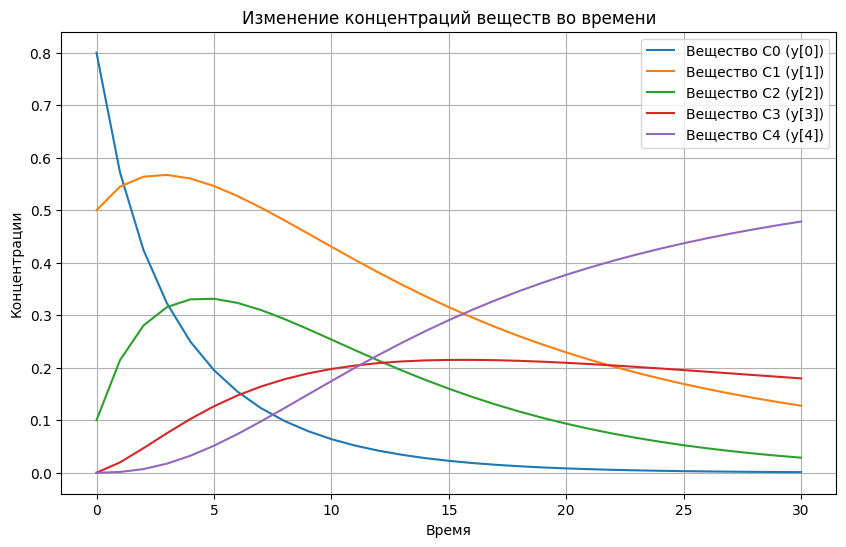

Начальные концентрации:        [0.8 0.5 0.1 0.  0. ]
Сумма концентраций веществ:  1.4000000000000001
Концентрации после 30 секунд: [0.00135553 0.1347056  0.03239029 0.18281589 0.47134237]
Сумма концентрций веществ:  0.8226096690921885


In [12]:
sol = solve_ivp(
        true_ode_func,              # Функция ОДУ
        tspan,                      # Интервал времени
        INIT_CONC,                         # Начальные условия
        args=(k,),                  # Передача параметров в функцию
        method='RK45',              # Метод решения
        t_eval=tsteps               # Точки, в которых сохраняется решение (Шаг)
    )

# Построение графиков
plt.figure(figsize=(10, 6))
for i in range(N_SUBSTANCE):
    plt.plot(sol.t, sol.y[i], label=f'Вещество C{i} (y[{i}])')

plt.title('Изменение концентраций веществ во времени')
plt.xlabel('Время')
plt.ylabel('Концентрации')
plt.legend()
plt.grid(True)
plt.show()

print("Начальные концентрации:       ", INIT_CONC)
print("Сумма концентраций веществ: ", sum(INIT_CONC))
print(f"Концентрации после {VR_TIME} секунд: {sol.y[:, VR_TIME - 1]}")
print("Сумма концентрций веществ: ", sum(sol.y[:, VR_TIME - 1]))


In [21]:
true_values = sol.y.copy()    # сохранение промежуточных результатов. Понадобятся в будущем

# Добавление шума

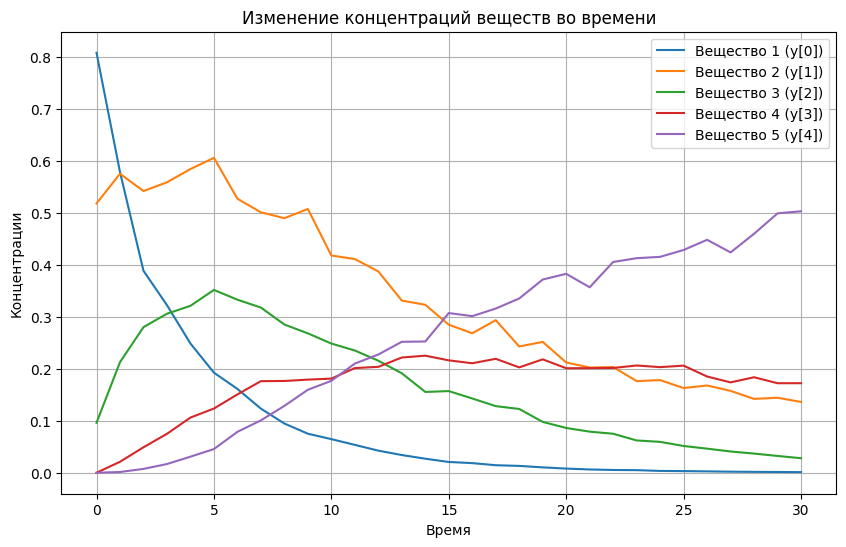

In [23]:
# Генерация шума
noise_level = 5e-2                # Уровень шума

time_vec = sol.t.reshape(-1, 1)   # Изменение формата временного шага для метода из sklearn

# Построение графиков
plt.figure(figsize=(10, 6))
for i in range(N_SUBSTANCE):
    noise = np.random.randn(*sol.y[i].shape) * sol.y[i] * noise_level
    sol.y[i] = sol.y[i] + noise
    plt.plot(sol.t, sol.y[i], label=f'Вещество {i+1} (y[{i}])')

plt.title('Изменение концентраций веществ во времени')  
plt.xlabel('Время')
plt.ylabel('Концентрации')
plt.legend()
plt.grid(True)
plt.show()


# Построение полиномиальных аппроксимаций функций изменения концентраций

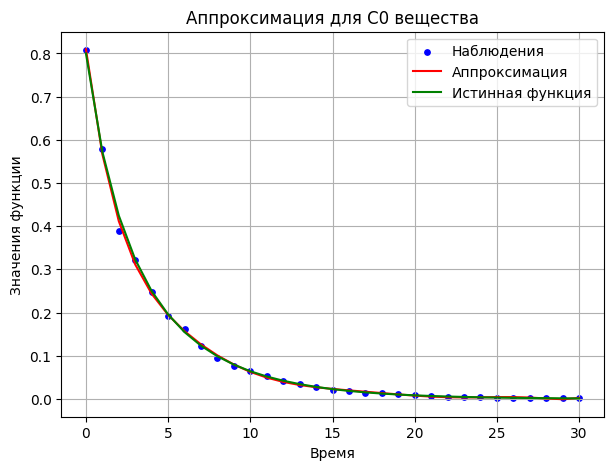

Для C0 вещества:
--------------------------------------------------
Коэффициент детерминации R^2: 0.99906627
Коэффициенты полинома:
[[ 0.00000000e+00 -3.03039057e-01  6.87437079e-02 -1.00268823e-02
   9.10559856e-04 -5.06249812e-05  1.66946810e-06 -2.99215147e-08
   2.24226693e-10]]
Свободный член: 0.80965612



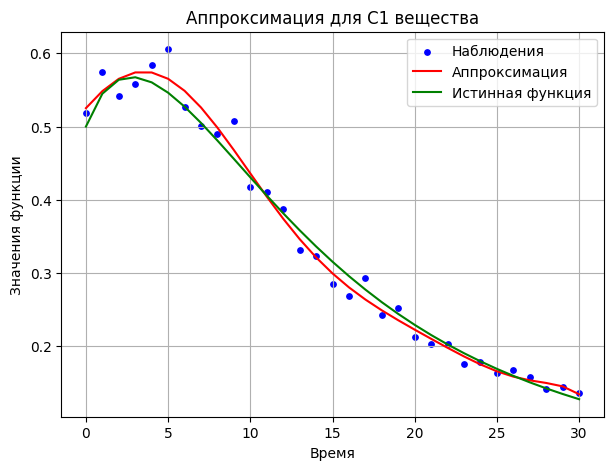

Для C1 вещества:
--------------------------------------------------
Коэффициент детерминации R^2: 0.98866826
Коэффициенты полинома:
[[ 0.00000000e+00  2.56574457e-02 -1.91586652e-03 -5.40199692e-04
   4.47828070e-05  3.08387652e-07 -1.35274871e-07  4.79664413e-09
  -5.32021302e-11]]
Свободный член: 0.52512109



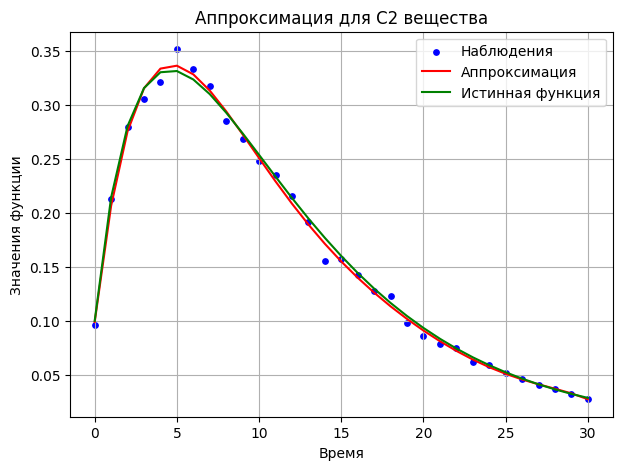

Для C2 вещества:
--------------------------------------------------
Коэффициент детерминации R^2: 0.99644131
Коэффициенты полинома:
[[ 0.00000000e+00  1.30529668e-01 -2.49134882e-02  2.09002036e-03
  -9.87571130e-05  2.78498103e-06 -4.80345740e-08  5.29028025e-10
  -3.39919759e-12]]
Свободный член: 0.09894644



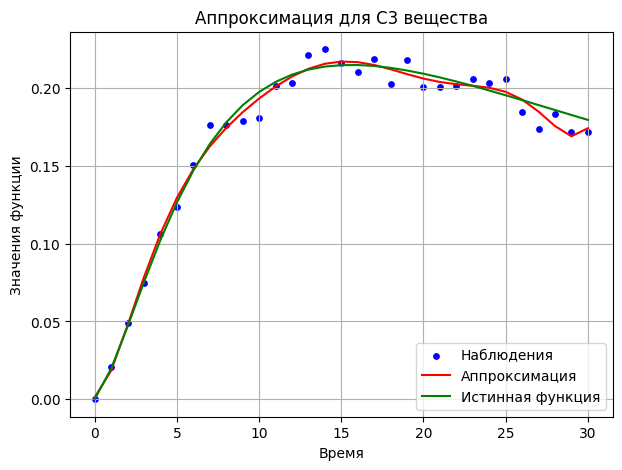

Для C3 вещества:
--------------------------------------------------
Коэффициент детерминации R^2: 0.98821883
Коэффициенты полинома:
[[ 0.00000000e+00  5.93358020e-03  1.45727104e-02 -3.78869680e-03
   4.62981542e-04 -3.15444621e-05  1.21519817e-06 -2.46814454e-08
   2.05141851e-10]]
Свободный член: 0.00121225



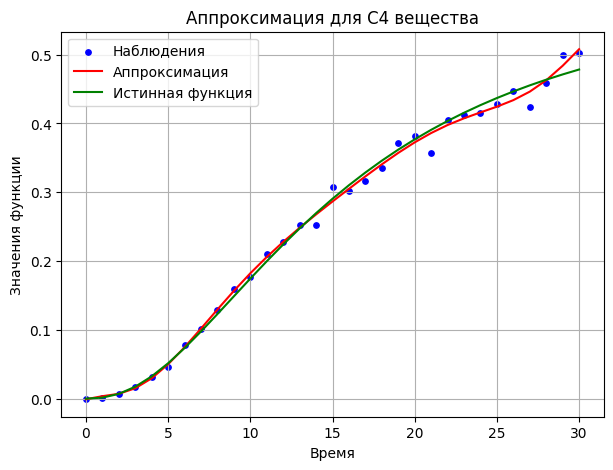

Для C4 вещества:
--------------------------------------------------
Коэффициент детерминации R^2: 0.99619596
Коэффициенты полинома:
[[ 0.00000000e+00  8.06213545e-03 -5.81802043e-03  2.48386580e-03
  -3.48785514e-04  2.45623733e-05 -9.38647043e-07  1.85534091e-08
  -1.48452911e-10]]
Свободный член: -0.00087192



In [40]:
# Преобразование признаков в полиномиальные
poly = PolynomialFeatures(degree=8)
t_poly = poly.fit_transform(time_vec)

for i in range(N_SUBSTANCE):
    y = sol.y[i].reshape(-1, 1)  # значения функции как 2D массив

    # Создаем и обучаем модель полиномиальной регрессии
    model = LinearRegression()
    model.fit(t_poly, y)
    y_pred = model.predict(t_poly)

    # Создаем отдельный график для каждого вещества
    plt.figure(figsize=(7, 5))  # Новый график
    plt.scatter(time_vec, y, color='blue', label='Наблюдения', s=15)
    plt.plot(time_vec, y_pred, color='red', label='Аппроксимация')
    plt.plot(time_vec, true_values[i], color='green', label=f'Истинная функция')

    plt.title(f'Аппроксимация для C{i} вещества')
    plt.xlabel('Время')
    plt.ylabel('Значения функции')
    plt.legend()
    plt.grid()
    plt.show()

    # Параметры модели
    r2 = model.score(t_poly, y)
    print(f"Для C{i} вещества:")
    print("-" * 50)  # разделитель
    print(f"Коэффициент детерминации R^2: {r2:.8f}")
    print("Коэффициенты полинома:")
    print(model.coef_)
    print(f"Свободный член: {model.intercept_[0]:.8f}")
    print()


## Построение графиков на одном листе

### Добавление вычисления MSE и скалярного произведения между истинной и аппрокcимационной функциями

Для C0-го вещества:
MSE: 0.06789486703997281
Скалярное произведение: 1.4128883447265326
Косинус угла (нормализованное скалярное произведение): 0.9998213369921524
--------------------------------------------------

Для C1-го вещества:
MSE: 0.04777598152175167
Скалярное произведение: 4.280132922788817
Косинус угла (нормализованное скалярное произведение): 0.9995526835377385
--------------------------------------------------

Для C2-го вещества:
MSE: 0.021544227251672037
Скалярное произведение: 1.1686800298585225
Косинус угла (нормализованное скалярное произведение): 0.9998517546693064
--------------------------------------------------

Для C3-го вещества:
MSE: 0.006858650691345582
Скалярное произведение: 1.0055387165639793
Косинус угла (нормализованное скалярное произведение): 0.9997876372939215
--------------------------------------------------

Для C4-го вещества:
MSE: 0.052856869753795534
Скалярное произведение: 2.914661170866733
Косинус угла (нормализованное скалярное произведение): 

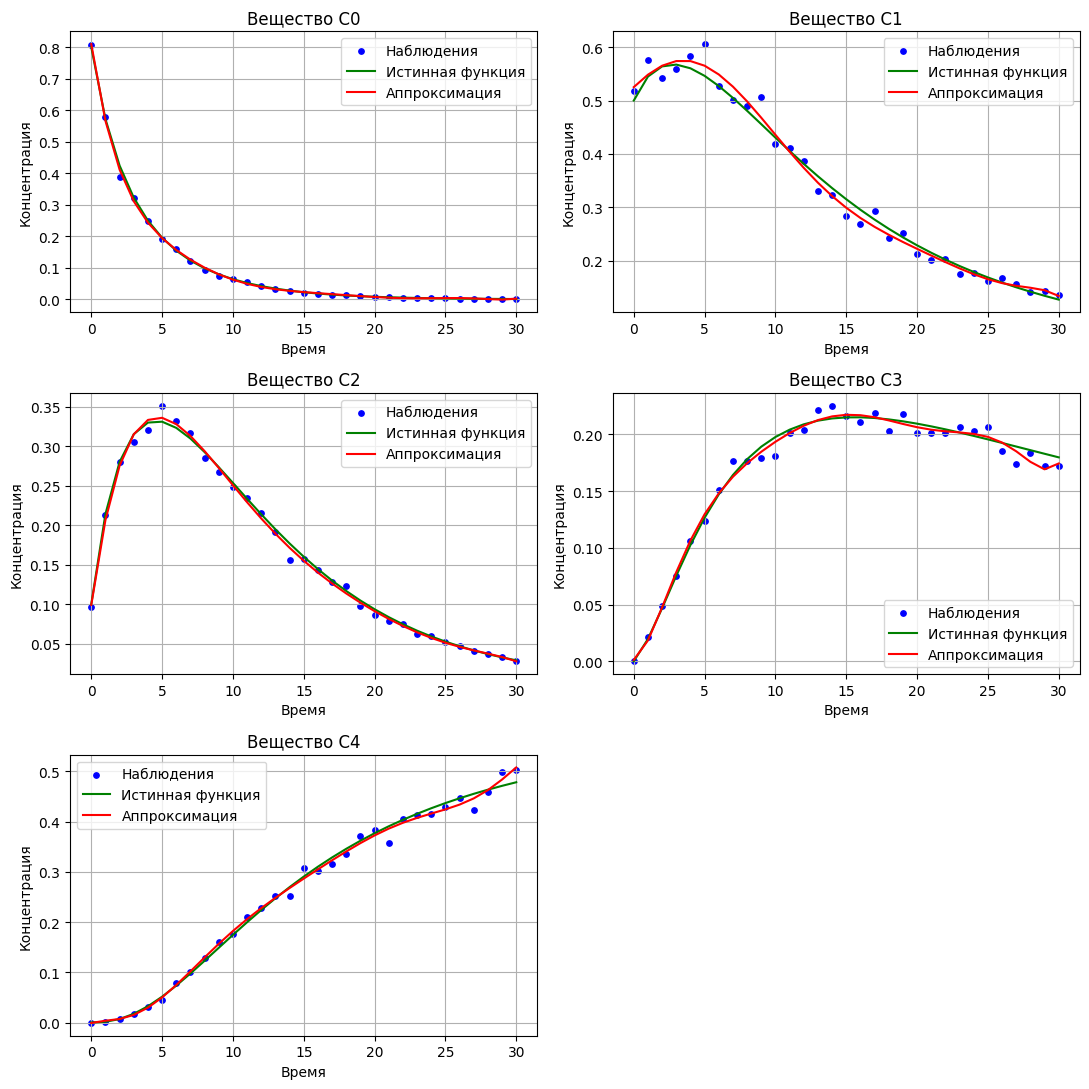

In [49]:
# Преобразование признаков в полиномиальные
poly = PolynomialFeatures(degree=8)
t_poly = poly.fit_transform(time_vec)

# Определяем количество строк и столбцов для сетки графиков
rows, cols = (3, 2)  # Подходит для N_SUBSTANCE = 6
fig, axes = plt.subplots(rows, cols, figsize=(11,11))  # Размер общего окна

# Перебираем вещества и оси для графиков
for i in range(N_SUBSTANCE):
    y = sol.y[i].reshape(-1, 1)  # значения функции как 2D массив

    # Создаем и обучаем модель полиномиальной регрессии
    model = LinearRegression()
    model.fit(t_poly, y)
    y_pred = model.predict(t_poly)

    # MSE
    mse = np.mean((y_pred - true_values[i])**2)
    print(f'Для C{i}-го вещества:')
    print("MSE:", mse)

    # Скалярное произведение и косинус угла
    dot_product = np.sum(y_pred.flatten() * true_values[i])  # Скалярное произведение
    norm_true = np.sqrt(np.sum(true_values[i]**2))   # Норма истинной функции
    norm_approx = np.sqrt(np.sum(y_pred**2))         # Норма аппроксимации
    cos_theta = dot_product / (norm_true * norm_approx)

    print("Скалярное произведение:", dot_product)
    print("Косинус угла (нормализованное скалярное произведение):", cos_theta)
    print('-' * 50)
    print()

    # Определяем текущую ось
    ax = axes[i // cols, i % cols]
    
    # Строим график
    ax.scatter(time_vec, y, color='blue', label='Наблюдения', s=15)
    ax.plot(sol.t, true_values[i], color='green', label=f'Истинная функция')
    ax.plot(time_vec, y_pred, color='red', label='Аппроксимация')
    
    # Настройка графика
    ax.set_title(f'Вещество C{i}')
    ax.set_xlabel('Время')
    ax.set_ylabel('Концентрация')
    ax.legend()
    ax.grid()

# Убираем пустые графики, если их больше нет
for j in range(N_SUBSTANCE, rows * cols):
    fig.delaxes(axes[j // cols, j % cols])

plt.tight_layout()  # Автоматическая подгонка расстояний
plt.show()
